In [390]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, InputLayer
from tensorflow.keras import optimizers
from tensorflow.keras import initializers

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [96]:
#get data from various folders
#training / validation ratio = 9/1

import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
seed= 12

datagen = ImageDataGenerator(
    rescale = 1./255, #rescale pixel values for CNN
    validation_split = 0.1
)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_ds = datagen.flow_from_directory(
    directory='datasets/MagnaTagATune/spec_train/',
    class_mode='categorical',
    batch_size=10,
    color_mode = "grayscale",
    target_size=(64,128), # rescale images while maintaining proportions, reduce params
    subset = "training",
    shuffle = True
)

val_ds = datagen.flow_from_directory(
    directory='datasets/MagnaTagATune/spec_train/',
    class_mode='categorical',
    batch_size=10,
    color_mode = "grayscale",
    target_size=(64,128),
    subset = "validation",
    shuffle = True
)

#no shuffle
test_ds = test_datagen.flow_from_directory(
    directory='datasets/MagnaTagATune/spec_test/',
    class_mode='categorical',
    color_mode = "grayscale",
    target_size=(64,128),
)


Found 3645 images belonging to 2 classes.
Found 405 images belonging to 2 classes.
Found 450 images belonging to 2 classes.


In [170]:
from sklearn.metrics import f1_score, confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

#Metrics for evaluation
def compute_f1(y_true,y_pred):
    val = f1_score(y_true,y_pred,average = None)
    return val

def get_predictions(nn,test):
    print("Getting predictions ...")
    predictions = nn.predict(test)
    # adjusts predictions into True, False format
    predictions = predictions > 0.5
    y_pred = []
    # reformat predictions as binary
    for pred in predictions:
        if pred[0] == True:
            y_pred.append(0)
        else:
            y_pred.append(1)
    return y_pred

# CNN based Spectrogram Analysis

## Experiment 1(time-dimension focus)
#####  "This was repeated( to test consistency of early stopping - both times only ran 22 - 25 epochs)" 

- Architecture with 4 layers - Conv2D followed by Batch Norm followed by MaxPooling (preferred over average pooling in the spotify article because I'm trying to detect some form of onset) 
- using the he normal initializer
- Batch size = 10, steps_per_epoch = 10, shuffle = True
- This gives us around 100 images per epoch - training runs for around 1.5 hours each time

#### Callbacks
- Best checkpoint - measured against val loss (val accuracy might be better to grab the best model for this binary case, but val loss would be better once more classes are included as a possible future work) 
- Early stopping - Patience = 20 
- Live Loss Plot Lib




In [171]:

seed = 6

model = tf.keras.models.Sequential()

model.add(Conv2D(filters = 128, kernel_size = (4,64), activation = "relu", kernel_initializer = initializers.he_normal(seed = seed),input_shape = (64,128,1), padding = 'SAME'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(4,4)))

model.add(Conv2D(filters = 256, kernel_size = (4,32), activation = "relu", kernel_initializer = initializers.he_normal(seed=seed),padding = 'SAME'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 256, kernel_size = (4,16),activation = "relu", kernel_initializer = initializers.he_normal(seed=seed),padding = 'SAME'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 512, kernel_size = (4,8), activation = "relu",kernel_initializer = initializers.he_normal(seed=seed),padding = 'SAME'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512, activation="relu", kernel_initializer=initializers.he_normal(seed=seed)))
model.add(Dropout(0.3))
model.add(Dense(256, activation="relu", kernel_initializer=initializers.he_normal(seed=seed)))
model.add(Dropout(0.3))
model.add(Dense(64, activation="relu", kernel_initializer=initializers.he_normal(seed=seed)))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

model.compile(loss="categorical_crossentropy", 
                  optimizer=optimizers.Nadam(learning_rate = 0.0001),
                  metrics=["accuracy"])

model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 64, 128, 128)      32896     
_________________________________________________________________
batch_normalization_100 (Bat (None, 64, 128, 128)      512       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 32, 128)       0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 16, 32, 256)       4194560   
_________________________________________________________________
batch_normalization_101 (Bat (None, 16, 32, 256)       1024      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 8, 16, 256)        0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 8, 16, 256)      

In [185]:
from livelossplot import PlotLossesKeras

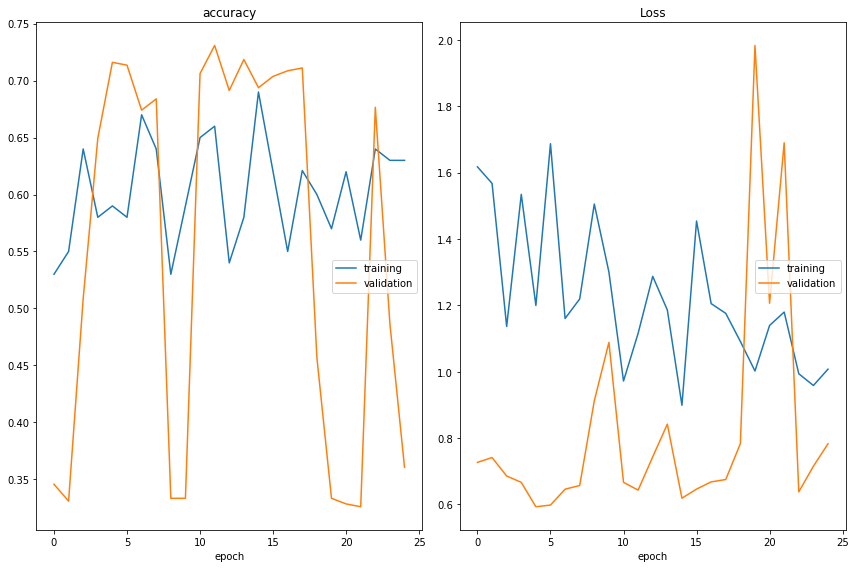

accuracy
	training         	 (min:    0.530, max:    0.690, cur:    0.630)
	validation       	 (min:    0.326, max:    0.731, cur:    0.360)
Loss
	training         	 (min:    0.899, max:    1.687, cur:    1.008)
	validation       	 (min:    0.593, max:    1.984, cur:    0.783)
10/10 [==============================] - 53s 5s/step - loss: 1.0077 - accuracy: 0.6300 - val_loss: 0.7827 - val_accuracy: 0.3605


In [173]:
early_stopping = keras.callbacks.EarlyStopping(patience = 20,restore_best_weights=True)
plotlosses = PlotLossesKeras()
best_checkpoint = keras.callbacks.ModelCheckpoint("rect(4x64)_experiment4.h5", monitor ='val_loss', save_best_only = True, mode = 'min')

history = model.fit(train_ds, 
                    validation_data = val_ds,
                    epochs=100, 
                    callbacks = [early_stopping, best_checkpoint,plotlosses],
                    steps_per_epoch = 10)

In [400]:
score = model.evaluate(test_ds)
y_pred = get_predictions(model, test_ds)
y_true = test_ds.classes

15/15 [==============================] - 26s 2s/step - loss: 0.6295 - accuracy: 0.6822
Getting predictions ...


[0.15873016 0.77637131]


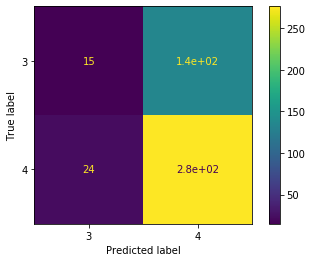

In [401]:
mat1 = confusion_matrix(y_true, y_pred)
print(compute_f1(y_true,y_pred))
ConfusionMatrixDisplay(mat1,display_labels = [3,4]).plot()

In [ ]:
# experiment4 = history.history
# pd.DataFrame(experiment4).to_csv("experiment4.csv")

## Experiment 2 (frequency-dimension focus)

In [124]:
model2 = tf.keras.models.Sequential()

model2.add(Conv2D(filters = 128, kernel_size = (64,4), activation = "relu", kernel_initializer = initializers.he_normal(seed = seed),input_shape = (64,128,1), padding = 'SAME'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(4,4)))

model2.add(Conv2D(filters = 256, kernel_size = (32,4), activation = "relu", kernel_initializer = initializers.he_normal(seed=seed),padding = 'SAME'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(filters = 256, kernel_size = (16,4),activation = "relu", kernel_initializer = initializers.he_normal(seed=seed),padding = 'SAME'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(filters = 512, kernel_size = (8,4), activation = "relu",kernel_initializer = initializers.he_normal(seed=seed),padding = 'SAME'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Flatten())
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

model2.add(Dense(512, activation="relu", kernel_initializer=initializers.he_normal(seed=seed)))
model2.add(Dropout(0.3))
model2.add(Dense(256, activation="relu", kernel_initializer=initializers.he_normal(seed=seed)))
model2.add(Dropout(0.3))
model2.add(Dense(64, activation="relu", kernel_initializer=initializers.he_normal(seed=seed)))
model2.add(Dropout(0.3))
model2.add(Dense(2, activation='softmax'))

model2.compile(loss="categorical_crossentropy", 
                  optimizer=optimizers.Nadam(learning_rate = 0.0001),
                  metrics=["accuracy"])

model2.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 64, 128, 128)      32896     
_________________________________________________________________
batch_normalization_90 (Batc (None, 64, 128, 128)      512       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 32, 128)       0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 16, 32, 256)       4194560   
_________________________________________________________________
batch_normalization_91 (Batc (None, 16, 32, 256)       1024      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 16, 256)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 8, 16, 256)      

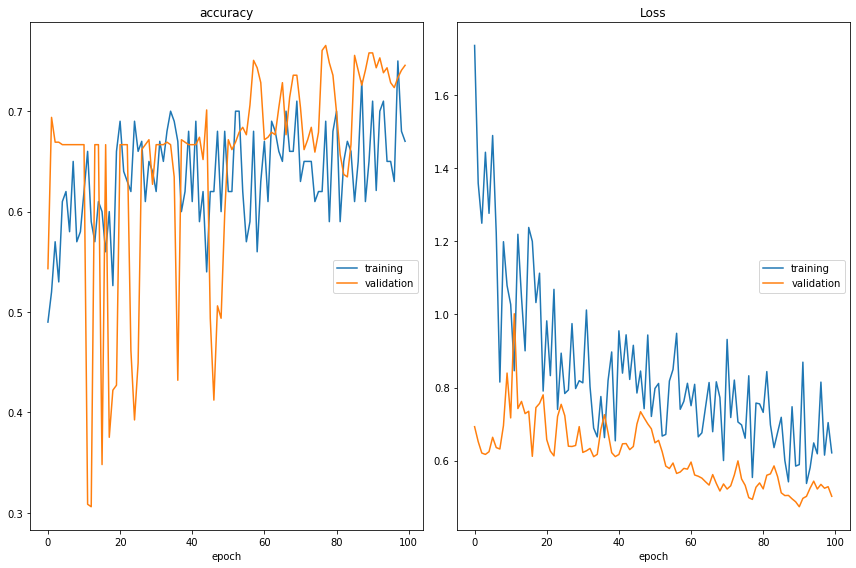

accuracy
	training         	 (min:    0.490, max:    0.750, cur:    0.670)
	validation       	 (min:    0.306, max:    0.765, cur:    0.746)
Loss
	training         	 (min:    0.538, max:    1.735, cur:    0.621)
	validation       	 (min:    0.474, max:    1.002, cur:    0.503)
10/10 [==============================] - 52s 5s/step - loss: 0.6215 - accuracy: 0.6700 - val_loss: 0.5027 - val_accuracy: 0.7457


In [125]:
early_stopping = keras.callbacks.EarlyStopping(patience = 20,restore_best_weights=True)
plotlosses = PlotLossesKeras()
best_checkpoint = keras.callbacks.ModelCheckpoint("rect(32x4)_checkpoint.h5", monitor ='val_loss', save_best_only = True, mode = 'min')

history2 = model2.fit(train_ds, 
                    validation_data = val_ds,
                    epochs=100, 
                    callbacks = [early_stopping, best_checkpoint,plotlosses],
                    steps_per_epoch = 10)

In [131]:
score = model2.evaluate(test_ds)

15/15 [==============================] - 28s 2s/step - loss: 0.5630 - accuracy: 0.7044


In [158]:
y_pred2 = get_predictions(model2, test_ds)

Getting predictions ...
[[False  True]
 [False  True]
 [ True False]
 [ True False]
 [ True False]
 [False  True]
 [False  True]
 [ True False]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [ True False]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [ True False]
 [ True False]
 [False  True]
 [False  True]
 [ True False]
 [False  True]
 [False  True]
 [ True False]
 [False  True]
 [False  True]
 [ True False]
 [ True False]
 [ True False]
 [ True False]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [ True False]
 [ True False]
 [False  True]
 [ True False]
 [ True False]
 [False  True]
 [ True False]
 [False  True]
 [False  True]
 [False  True]
 [ True False]
 [ True False]
 [ True False]
 [ True False]
 [ True False]
 [False  True]
 [False  True]
 [ True False]
 [ True False]
 [False  True]
 [False  True]
 [ True False]
 [False  True]
 

[0.3942029  0.62342342]


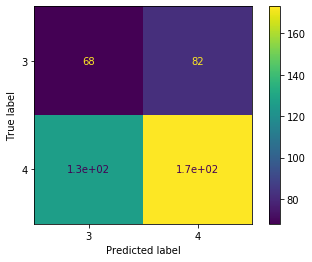

In [168]:
mat2 = confusion_matrix(y_true, y_pred2)
print(compute_f1(y_true,y_pred2))
ConfusionMatrixDisplay(mat2,display_labels = [3,4]).plot()

## Experiment 3 (Regular Square Kernels)

In [160]:
model3 = tf.keras.models.Sequential()

model3.add(Conv2D(filters = 128, kernel_size = (4,4), activation = "relu", kernel_initializer = initializers.he_normal(seed = seed),input_shape = (64,128,1), padding = 'SAME'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(4,4)))

model3.add(Conv2D(filters = 256, kernel_size = (4,4), activation = "relu", kernel_initializer = initializers.he_normal(seed=seed),padding = 'SAME'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(filters = 256, kernel_size = (4,4),activation = "relu", kernel_initializer = initializers.he_normal(seed=seed),padding = 'SAME'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(filters = 512, kernel_size = (4,4), activation = "relu",kernel_initializer = initializers.he_normal(seed=seed),padding = 'SAME'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Flatten())
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

model3.add(Dense(1024, activation="relu", kernel_initializer=initializers.he_normal(seed=seed)))
model3.add(Dropout(0.3))
model3.add(Dense(256, activation="relu", kernel_initializer=initializers.he_normal(seed=seed)))
model3.add(Dropout(0.3))
model3.add(Dense(64, activation="relu", kernel_initializer=initializers.he_normal(seed=seed)))
model3.add(Dropout(0.3))
model3.add(Dense(2, activation='softmax'))

model3.compile(loss="categorical_crossentropy", 
                  optimizer=optimizers.Nadam(learning_rate = 0.0001),
                  metrics=["accuracy"])

model3.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 64, 128, 128)      2176      
_________________________________________________________________
batch_normalization_95 (Batc (None, 64, 128, 128)      512       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 32, 128)       0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 16, 32, 256)       524544    
_________________________________________________________________
batch_normalization_96 (Batc (None, 16, 32, 256)       1024      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 16, 256)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 8, 16, 256)      

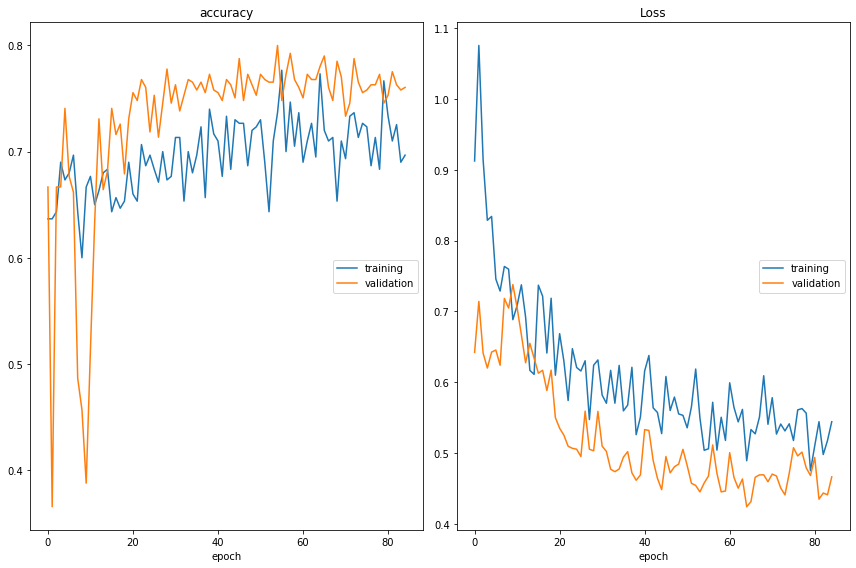

accuracy
	training         	 (min:    0.600, max:    0.777, cur:    0.697)
	validation       	 (min:    0.365, max:    0.800, cur:    0.760)
Loss
	training         	 (min:    0.475, max:    1.076, cur:    0.544)
	validation       	 (min:    0.424, max:    0.738, cur:    0.466)
30/30 [==============================] - 30s 990ms/step - loss: 0.5441 - accuracy: 0.6967 - val_loss: 0.4662 - val_accuracy: 0.7605


In [162]:
early_stopping = keras.callbacks.EarlyStopping(patience = 20,restore_best_weights=True)
plotlosses = PlotLossesKeras()
best_checkpoint = keras.callbacks.ModelCheckpoint("square(4x4)_experiment3.h5", monitor ='val_loss', save_best_only = True, mode = 'min')

history3 = model3.fit(train_ds, 
                    validation_data = val_ds,
                    epochs=100, 
                    callbacks = [early_stopping,best_checkpoint,plotlosses],
                    steps_per_epoch = 30)

In [164]:
score = model3.evaluate(test_ds)
y_pred3 = get_predictions(model3, test_ds)

15/15 [==============================] - 6s 419ms/step - loss: 0.5084 - accuracy: 0.7333
Getting predictions ...
[[ True False]
 [False  True]
 [ True False]
 [ True False]
 [ True False]
 [False  True]
 [False  True]
 [False  True]
 [ True False]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [ True False]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [ True False]
 [False  True]
 [False  True]
 [False  True]
 [ True False]
 [False  True]
 [ True False]
 [ True False]
 [ True False]
 [False  True]
 [ True False]
 [ True False]
 [ True False]
 [ True False]
 [ True False]
 [False  True]
 [False  True]
 [False  True]
 [ True False]
 [ True False]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [ True False]
 [False  True]
 [False  True]
 [False  True]
 [ True False]
 [False  True]
 [

[0.35333333 0.67666667]


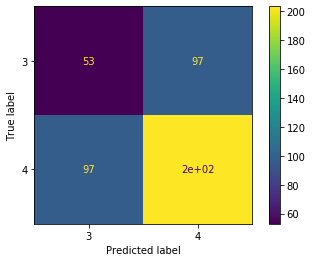

In [167]:
mat3 = confusion_matrix(y_true, y_pred3)
print(compute_f1(y_true,y_pred3))
ConfusionMatrixDisplay(mat3,display_labels = [3,4]).plot()

## Experiment 4 (Regular Square Kernels)

- From the earlier experiment, Square kernels performed best, also trained the fastest
- Results still indicate a skew towards class four
- Redistributed the dataset with 1k exampes per class 


In [407]:
#get data from various folders
# training / validation ratio = 9/1

import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
seed= 12

datagen = ImageDataGenerator(
    rescale = 1./255, #rescale pixel values for CNN
    validation_split = 0.1
)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_ds2 = datagen.flow_from_directory(
    directory='datasets/MagnaTagATune/spec_train2/',
    class_mode='categorical',
    batch_size=10,
    color_mode = "grayscale",
    target_size=(128,128), # rescale images while maintaining proportions - necessary for spectrograms
    subset = "training",
    shuffle = True
)

val_ds2 = datagen.flow_from_directory(
    directory='datasets/MagnaTagATune/spec_train2/',
    class_mode='categorical',
    batch_size=10,
    color_mode = "grayscale",
    target_size=(128,128),
    subset = "validation",
    shuffle = True
)



Found 4860 images belonging to 2 classes.
Found 540 images belonging to 2 classes.


In [408]:
#no shuffle
test_ds2 = test_datagen.flow_from_directory(
    directory='datasets/MagnaTagATune/spec_test2/',
    class_mode='categorical',
    color_mode = "grayscale",
    target_size=(128,128),
)


Found 600 images belonging to 2 classes.


In [192]:
model4 = tf.keras.models.Sequential()

model4.add(Conv2D(filters = 128, kernel_size = (4,4), activation = "relu", kernel_initializer = initializers.he_normal(seed = seed),input_shape = (128,128,1), padding = 'SAME'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(4,4)))

model4.add(Conv2D(filters = 256, kernel_size = (4,4), activation = "relu", kernel_initializer = initializers.he_normal(seed=seed),padding = 'SAME'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Conv2D(filters = 256, kernel_size = (4,4),activation = "relu", kernel_initializer = initializers.he_normal(seed=seed),padding = 'SAME'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Conv2D(filters = 512, kernel_size = (4,4), activation = "relu",kernel_initializer = initializers.he_normal(seed=seed),padding = 'SAME'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Flatten())
model4.add(BatchNormalization())
model4.add(Dropout(0.5))

model4.add(Dense(1024, activation="relu", kernel_initializer=initializers.he_normal(seed=seed)))
model4.add(Dropout(0.3))
model4.add(Dense(256, activation="relu", kernel_initializer=initializers.he_normal(seed=seed)))
model4.add(Dropout(0.3))
model4.add(Dense(64, activation="relu", kernel_initializer=initializers.he_normal(seed=seed)))
model4.add(Dropout(0.3))
model4.add(Dense(2, activation='softmax'))

model4.compile(loss="categorical_crossentropy", 
                  optimizer=optimizers.Nadam(learning_rate = 0.0001),
                  metrics=["accuracy"])

model4.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_113 (Conv2D)          (None, 128, 128, 128)     2176      
_________________________________________________________________
batch_normalization_135 (Bat (None, 128, 128, 128)     512       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 32, 32, 256)       524544    
_________________________________________________________________
batch_normalization_136 (Bat (None, 32, 32, 256)       1024      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 16, 16, 256)     

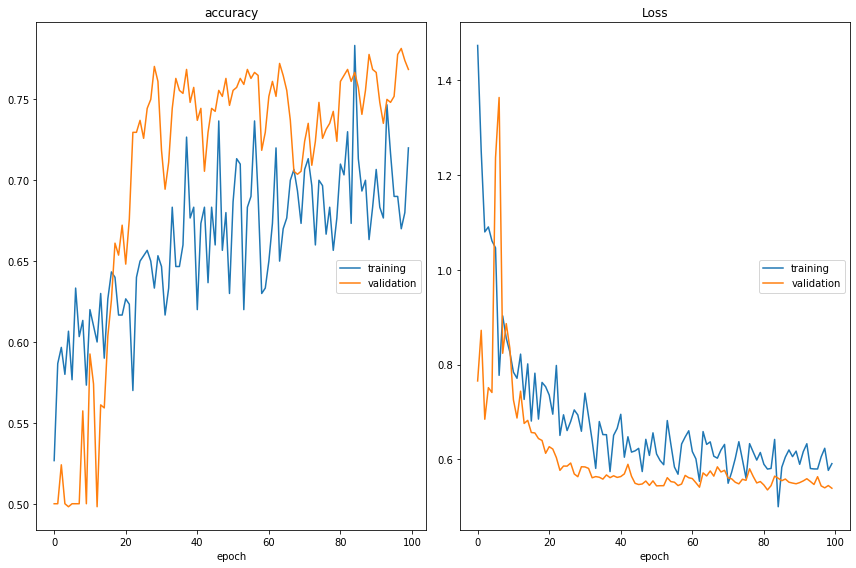

accuracy
	training         	 (min:    0.527, max:    0.783, cur:    0.720)
	validation       	 (min:    0.498, max:    0.781, cur:    0.769)
Loss
	training         	 (min:    0.500, max:    1.473, cur:    0.591)
	validation       	 (min:    0.536, max:    1.364, cur:    0.539)
30/30 [==============================] - 68s 2s/step - loss: 0.5911 - accuracy: 0.7200 - val_loss: 0.5392 - val_accuracy: 0.7685


In [193]:
early_stopping = keras.callbacks.EarlyStopping(patience = 20,restore_best_weights=True)
plotlosses = PlotLossesKeras()
best_checkpoint = keras.callbacks.ModelCheckpoint("square(4x4)_experiment4.h5", monitor ='val_loss', save_best_only = True, mode = 'min')

history4 = model4.fit(train_ds2, 
                    validation_data = val_ds2,
                    epochs=100, 
                    callbacks = [early_stopping,best_checkpoint,plotlosses],
                    steps_per_epoch = 30)

In [443]:
score = model5.evaluate(test_ds2)
y_pred4 = get_predictions(model5, test_ds2)
y_true2 = test_ds2.classes

19/19 [==============================] - 23s 1s/step - loss: 0.5835 - accuracy: 0.7100
Getting predictions ...


[0.53538462 0.45090909]


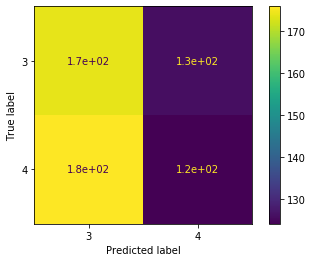

In [444]:
mat4 = confusion_matrix(y_true2, y_pred4)
print(compute_f1(y_true2,y_pred4))
ConfusionMatrixDisplay(mat4,display_labels = [3,4]).plot()

In [202]:
# experiment5 = (history5.history)
# pd.DataFrame(experiment5).to_csv("experiment5.csv")

# Experiment 5 - Transfer Learner

- Requires RGB channels, so we can re-instantiate the data with the RGB color mode
- Using ResNet50 as the core network

In [434]:
img_size = 128
datagen = ImageDataGenerator(
    rescale = 1./255, #rescale pixel values for CNN
    validation_split = 0.1 
)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_ds3 = datagen.flow_from_directory(
    directory='datasets/MagnaTagATune/spec_train2/',
    class_mode='categorical',
    color_mode = "rgb",
    batch_size = 10, 
    target_size=(img_size,img_size),
    subset = "training",
    shuffle = True
)

val_ds3 = datagen.flow_from_directory(
    directory='datasets/MagnaTagATune/spec_train2/',
    class_mode='categorical',
    batch_size = 10,
    color_mode = "rgb",
    target_size=(img_size,img_size),
    subset = "validation",
    shuffle = True
)


test_ds3 = test_datagen.flow_from_directory(
    directory='datasets/MagnaTagATune/spec_test2/',
    class_mode='categorical',
    color_mode = "rgb",
    batch_size = 10,
    target_size=(img_size,img_size),
)

Found 4860 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


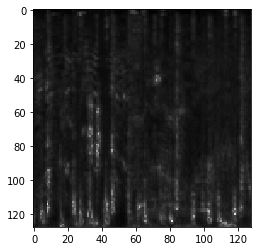

In [442]:
#img test
plt.imshow(train_ds3[0][0][1])

In [431]:
from tensorflow.keras.models import Model
 #generate core body using ResNet50
core = keras.applications.ResNet50(include_top=False,
                                   weights='imagenet',
                                   input_shape=(img_size,img_size,3)) 

output = core.layers[-1].output
output = keras.layers.Flatten()(output) #flattened output before adding Dense layers

core = Model(inputs = core.input, outputs=output)

core.trainable = False
core.summary()

Model: "functional_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_45[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________

In [439]:
denseLayers = tf.keras.models.Sequential()
# create dense network structure
denseLayers.add(Dense(1024, activation="relu", kernel_initializer=initializers.he_normal(seed=seed)))
denseLayers.add(Dropout(0.3))
denseLayers.add(Dense(256, activation="relu", kernel_initializer=initializers.he_normal(seed=seed)))
denseLayers.add(Dense(64, activation="relu", kernel_initializer=initializers.he_normal(seed=seed)))
denseLayers.add(Dense(2, activation='softmax'))

for layer in core.layers:
    layer.trainable = False# Frozen Layer - Fine Tune when implementation works?
# combine to form ful model
model5 = tf.keras.models.Sequential()
model5.add(core)
model5.add(denseLayers)

model5.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Nadam(0.0001),
              metrics=['accuracy'])

model5.summary()

Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_32 (Functional)   (None, 32768)             23587712  
_________________________________________________________________
sequential_101 (Sequential)  (None, 2)                 33818370  
Total params: 57,406,082
Trainable params: 33,818,370
Non-trainable params: 23,587,712
_________________________________________________________________


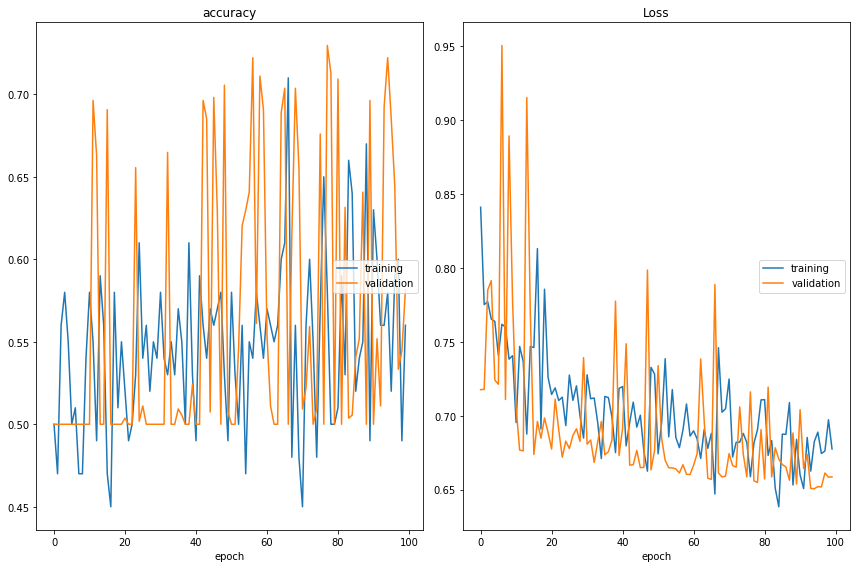

accuracy
	training         	 (min:    0.450, max:    0.710, cur:    0.560)
	validation       	 (min:    0.500, max:    0.730, cur:    0.581)
Loss
	training         	 (min:    0.638, max:    0.841, cur:    0.677)
	validation       	 (min:    0.651, max:    0.950, cur:    0.659)
10/10 [==============================] - 32s 3s/step - loss: 0.6775 - accuracy: 0.5600 - val_loss: 0.6586 - val_accuracy: 0.5815


In [440]:
early_stopping = keras.callbacks.EarlyStopping(patience = 20,restore_best_weights=True)
plotlosses = PlotLossesKeras()
best_checkpoint = keras.callbacks.ModelCheckpoint("transfer_full_1.h5", monitor ='val_loss', save_best_only = True, mode = 'min')

history5 = model5.fit(train_ds3,
                    validation_data = val_ds3,
                    epochs=100, 
                    steps_per_epoch = 10,
                    callbacks = [early_stopping,best_checkpoint,plotlosses])

In [450]:
score = model5.evaluate(test_ds3)
y_pred5 = get_predictions(model5, test_ds3)
y_true3 = test_ds4.classes

60/60 [==============================] - 31s 525ms/step - loss: 0.6690 - accuracy: 0.5467
Getting predictions ...


[0.63058824 0.10285714]


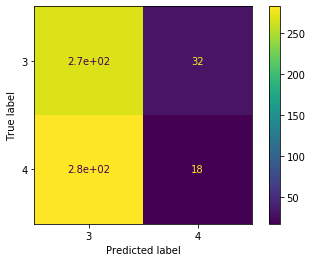

In [451]:
mat5 = confusion_matrix(y_true3, y_pred5)
print(compute_f1(y_true3,y_pred5))
ConfusionMatrixDisplay(mat5,display_labels = [3,4]).plot()

### Points for self 

- Explore the use of L1/L2 regularization in the future
- Rectangular kernels for Pooling Layers as well